<a href="https://colab.research.google.com/github/Echo9k/ml-trading-strategy/blob/main/notebooks/Milestone_2_Starter_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Engineering Predictive Alpha Factors

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd '/gdrive/My Drive/data'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/data


This notebook illustrates the following steps:

1. Select the adjusted open, high, low, and close prices as well as the volume for all tickers from the Quandl Wiki data that you downloaded and simplified for the last milestone for the 2007-2016 time period. Looking ahead, we will use 2014-2016 as our 'out-of-sample' period to test the performance of a strategy based on a machine learning model selected using data from preceding periods.
2. Compute the dollar volume as the product of closing price and trading volume; then select the stocks with at least eight years of data and the lowest average daily rank for this metric. 
3. Compute daily returns and keep only 'inliers' with values between -100% and + 100% as a basic check against data error.
4. Now we're ready to compute financial features. The Alpha Factory Library listed among the resources below illustrates how to compute a broad range of those using pandas and TA-Lib. We will list a few examples; feel free to explore and evaluate the various TA-Lib indicators.
    - Compute **historical returns** for various time ranges such as 1, 3, 5, 10, 21 trading days, as well as longer periods like 2, 3, 6 and 12 months.
    - Use TA-Lib's **Bollinger Band** indicator to create features that anticipate **mean-reversion**.
    - Select some indicators from TA-Lib's **momentum** indicators family such as
        - the Average Directional Movement Index (ADX), 
        - the Moving Average Convergence Divergence (MACD), 
        - the Relative Strength Index (RSI), 
        - the Balance of Power (BOP) indictor, or 
        - the Money Flow Index (MFI).
    - Compute TA-Lib **volume** indicators like On Balance Volume (OBV) or the Chaikin A/D Oscillator (ADOSC)
    - Create volatility metrics such as the Normalized Average True Range (NATR).
    - Compute rolling factor betas using the five Fama-French risk factors for different rolling windows of three and 12 months (see resources below).
    - Compute the outcome variable that we will aim to predict, namely the 1-day forward returns.

## Usage tips

- If you experience resource constraints (suddenly restarting Kernel), increase the memory available for Docker Desktop (> Settings > Advanced). If this not possible or you experienced prolonged execution times, reduce the scope of the exercise. The easiest way to do so is to select fewer stocks or a shorter time period, or both.
- You may want to persist intermediate results so you can recover quickly in case something goes wrong. There's an example under the first 'Persist Results' subsection.

## Imports & Settings

In [ ]:
#@markdown Install missing libraries
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
!wget $url/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget $url/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install -q ta-lib
import talib

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

from pathlib import Path
from scipy import stats #
import numpy as np
import pandas as pd
import pandas_datareader.data as web

import statsmodels.api as sm
# from statsmodels.regression.rolling import RollingOLS
from sklearn.preprocessing import scale
from talib import MA_Type
import talib
from fastprogress.fastprogress import progress_bar


import matplotlib.pyplot as plt
import seaborn as sns
import pprint

from IPython.display import display

In [4]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1).round(1)

## Load Data

In [8]:
# DATA_STORE = Path('..', 'data', 'stock_prices.h5')
DATA_STORE = './stock_metrics.h5'

In [6]:
with pd.HDFStore(DATA_STORE) as store:
    data = pd.concat([store.get('/data/training'), 
                     store.get('/data/testing')])
    validation = store.get('/data/validation')

## Select 500 most-traded stocks prior to 2017


In [7]:
#@markdown Compute the dollar volume as the product of the adjusted close price and the adjusted volume:
data=data.assign(dollar_volume=data.close*data.volume)  # calculates dollar volume

In [8]:
#@markdown Keeps the most traded stocks
keep_top_ = 500 #@param {type:"number"}
most_traded_ticker = data.groupby('ticker')['dollar_volume'].sum().nlargest(keep_top_)  # Get the 500 most traded tickers
most_traded_data = data[np.in1d(data.index.get_level_values(1), most_traded_ticker.index)]  # filter data by the names above
most_traded_data.sample(5)  # Example

,,open,high,low,close,volume,dollar_volume
date,ticker,,,,,,
2006-02-13,NFLX,3.637143,3.638571,3.571429,3.604286,7714700.0,2.780598e+07
2006-02-27,SHLD,76.677616,78.921902,76.677616,78.582053,1145000.0,8.997645e+07
2010-11-09,BRCD,5.713926,5.798646,5.619792,5.648032,12915800.0,7.294885e+07
2006-10-05,MGM,41.286296,42.166622,41.226948,42.018252,1385300.0,5.820788e+07
2014-12-05,AVGO,99.413263,100.523812,97.393213,99.556869,2959623.0,2.946508e+08


Filter out data without at least 8 years of history and no gaps.

In [9]:
ticks_year_df = pd.DataFrame([[i.year,j] for i,j in zip(data.index.get_level_values(0),data.index.get_level_values(1))])  # Gets stock ticks and year
ticks_conditions = pd.DataFrame([ticks_year_df.groupby(1).max()[0]==2016,
                            ticks_year_df.groupby(1).nunique()[0]>7],
                            ['enough_data', 'until_2016'])
valid_ticks = ticks_conditions.all()
invalid_ticks = valid_ticks.apply(lambda x: not x)
invalid_ticks[True==invalid_ticks.values].index
data.drop(invalid_ticks[invalid_ticks.values==True].index
          , level=1
          , inplace=True
          )  # Drop the invalid ticks

## Remove outliers

### From daily returns
Remove outliners from daily returns

In [ ]:
#@title Outliners by daily returns
#@markdown Remove outliners based on their daily returns<br>
#@markdown _inverts the indexes_
def drop_daily_outliners(data):
    """Switches the order of the multi index to (tick, date)"""
    g = data['close'].pct_change(periods=1).groupby(['ticker'])
    too_high=pd.Series(g.max()>1).values
    too_small=pd.Series(g.min()<-1).values
    is_outliner = too_high * too_small  # is outliner? if too small or to high (boolean)
    indexes=g.max().index
    outliners = [k for k,v in zip(indexes, too_high) if v]
    inliners=set(indexes)-set(outliners)
    data = data.reset_index(level=0)
    return data.drop(outliners).set_index('date', append=True)

data = drop_daily_outliners(data)

,z
ticker,
BRK_A,22.259818
BTU,1.262600
ACI,0.620307
AIG,0.618700
C,0.480941


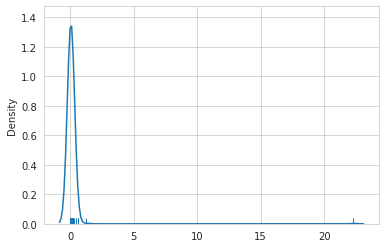

In [16]:
#@title zscores
#@markdown Calculates the z-scores
daily_returns = most_traded_data.close - most_traded_data.open
daily_returns_by_ticker=daily_returns.groupby('ticker').sum()
zscores = np.abs(stats.zscore(daily_returns_by_ticker))

z_values=pd.DataFrame(zscores, daily_returns_by_ticker.index, columns=['z'])
display(z_values.nlargest(5, columns='z'))

sns.distplot(zscores, rug=True, hist=False)

z    0.027094
z    0.678204
dtype: float64

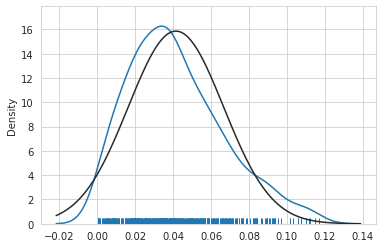

In [17]:
#@markdown How would it look with out the top_k outliners based on their zscore
top_k = 30 #@param{type:'number'}

no_outliners=z_values.nsmallest(z_values.shape[0] - top_k, columns='z')
display(pd.concat([no_outliners.kurtosis(), no_outliners.skew()]))
sns.distplot(no_outliners, rug=True, hist=False, fit=stats.norm)

In [19]:
#@markdown Remove outliners based on their zscore
large_ticks=z_values.nlargest(top_k, columns='z').index
data.drop(large_ticks, level=0, inplace=True)  # Drop the outliner ticks
display(data.shape)


(4042516, 6)

,,open,high,low,close,volume,dollar_volume
ticker,date,,,,,,
CRAY,2016-07-05,30.140000,30.140000,29.450000,29.750000,199120.0,5.923820e+06
ULTR,2009-12-31,4.920000,4.920000,4.760000,4.760000,84100.0,4.003160e+05
HZO,2016-06-10,16.450000,16.720000,16.350100,16.530000,195682.0,3.234623e+06
YHOO,2007-09-13,23.600000,23.960000,23.600000,23.720000,10309000.0,2.445295e+08
BPFH,2013-12-27,11.080827,11.107485,10.823133,11.071941,215100.0,2.381574e+06


## Compute Returns
- Daily
- Weekly
- Monthly
- Yearly

In [32]:
#@title Class Compute
#@markdown class Compute > Returns
class Compute:
    def __init__(self, data):
        self.data = data

    def timeline_column(self, company_name, column='close'):
        company_indexes=self.data.index.get_level_values(0)
        keep_idx=self.data.index.get_level_values(0)==company_name
        values = self.data[keep_idx][column].droplevel(0,0)
        return company_indexes[keep_idx], values
        
    def set_company_data(self, company_name):
        company_indexes=data.index.get_level_values(0)
        keep_idx=data.index.get_level_values(0)==company_name
        self.company_data = data[keep_idx]
        

class Returns(Compute):
    def __init__(self, data):
        super().__init__(data)

    def monthly(self, company_name):
        company_idx, close = self.timeline_column(company_name)
        
        returns=pd.DataFrame({
        'returns_M1':close.pct_change(1, freq = 'M'),
        'returns_M2':close.pct_change(2, freq = 'M'),
        'returns_M3':close.pct_change(3, freq = 'M'),
        'returns_M6':close.pct_change(6, freq = 'M'),
        'returns_Y1':close.pct_change(1, freq = 'Y')
        }).set_index(company_idx, append=True)
        return returns.swaplevel()

    def weekly(self, company_name):
        company_idx, close = self.timeline_column(company_name)

        returns=pd.DataFrame(
            {'returns_W1':close.pct_change(1, freq = 'W'),
            'returns_W3':close.pct_change(2, freq = 'W'),
            'returns_W5':close.pct_change(3, freq = 'W')}
        ).set_index(company_idx, append=True)
        return returns.swaplevel()

    def daily(self, company_name):
        company_idx, close = self.timeline_column(company_name)

        returns=pd.DataFrame(
            {'returns_D1':close.pct_change(periods=1),
            'returns_D3':close.pct_change(periods=3),
            'returns_D5':close.pct_change(periods=5),
            'returns_D10':close.pct_change(periods=10),
            'returns_D21':close.pct_change(periods=21)}
        ).set_index(company_idx, append=True)
        return returns.swaplevel()

    def all_returns(self, company_name):
        return pd.concat([self.daily(company_name),
                          self.weekly(company_name),
                          self.monthly(company_name)])

#  Calculate metrics

In [33]:
#@title class Metrics
class Metrics(Compute):
    """
    Calulates several metrics for a dataset with multiple indexes.
    """
    def __init__(self, data):
        super().__init__(data)

    def momentum_indicators(self):
        if company_name is not None:
            self.set_company_data(company_name)
        # Bollinger Bands
        self.company_data['SMA'] = talib.SMA(self.company_data.close.values)
        self.company_data['bb_upper'], self.company_data['bb_middle'], self.company_data['bb_lower'] = talib.BBANDS(self.company_data.close.values, matype=MA_Type.T3)
        self.company_data['momentum'] = talib.MOM(self.company_data.close.values, timeperiod=14)
        #Average Directional Movement Index (ADX)
        self.company_data['ADX'] = talib.ADX(self.company_data.high.values, self.company_data.low.values, self.company_data.close.values, timeperiod=14)
        # Absolute Price Oscillator (APO)
        self.company_data['APO'] = talib.APO(self.company_data.close.values)
        # Percentage Price Oscillator (PPO)
        self.company_data['PPO'] = talib.PPO(self.company_data.close.values)
        # Aroon Oscillator
        self.company_data['AROONOSC'] = talib.AROONOSC(self.company_data.high.values, self.company_data.low.values)
        # Balance of Power (BOP) indicator
        self.company_data['BOP'] = talib.BOP(self.company_data.open.values, self.company_data.high.values, self.company_data.low.values, self.company_data.close.values)
        # Commodity Channel Index (CCI)
        self.company_data['CCI'] = talib.CCI(self.company_data.high.values, self.company_data.low.values, self.company_data.close.values)
        # Moving Average Convergence Divergence (MACD),
        self.company_data.macd_fast, self.company_data.macd_slow, self.company_data.signal_period = talib.MACD(self.company_data.close.values)
        # Chande Momentum Oscillator (CMO)
        self.company_data['CMO'] = talib.CMO(self.company_data.close.values)
        # Flow Index (MFI)
        self.company_data['MFI'] = talib.MFI(self.company_data.high.values, self.company_data.low.values, self.company_data.close.values, self.company_data.volume.values, timeperiod=14)
        # Relative Strength Index (RSI)
        self.company_data['RSI'] = talib.RSI(self.company_data.close.values, timeperiod=14)
        #Stochastic RSI (STOCHRSI)
        self.company_data.fastk, self.company_data.fastd = talib.STOCHRSI(self.company_data.close.values)
        #Stochastic (STOCH)
        self.company_data.slowk, self.company_data.slowd = talib.STOCH(self.company_data.high.values, self.company_data.low.values, self.company_data.close.values)
        #Ultimate Oscillator (ULTOSC)
        self.company_data['ULTOSC'] = talib.ULTOSC(self.company_data.high.values, self.company_data.low.values, self.company_data.close.values)
        #Williams' %R (WILLR)
        self.company_data['WILLR'] = talib.WILLR(self.company_data.high.values, self.company_data.low.values, self.company_data.close.values, timeperiod=14)

    def volume_indicators(self):
        if company_name is not None:
            self.set_company_data(company_name)
        # Chaikin A/D Line
        self.company_data['AD'] = talib.AD(self.company_data.high.values, self.company_data.low.values, self.company_data.close.values, self.company_data.volume.values)
        #Chaikin A/D Oscillator (ADOSC)
        self.company_data['ADOSC'] = talib.ADOSC(self.company_data.high.values, self.company_data.low.values, self.company_data.close.values, self.company_data.volume.values)
        #On Balance Volume (OBV)
        self.company_data['OBV'] = talib.OBV(self.company_data.close.values, self.company_data.volume.values)

    def volatility_indicators(self, company_name=None):
        if company_name is not None:
            self.set_company_data(company_name)
        # ATR
        self.company_data['ATR'] = talib.ATR(self.company_data.high.values, self.company_data.low.values, self.company_data.close.values)
        #NATR
        self.company_data['NATR'] = talib.NATR(self.company_data.high.values, self.company_data.low.values, self.company_data.close.values)

    def all_metrics(self, company_name):
        self.set_company_data(company_name)
        self.volume_indicators()
        self.volatility_indicators()
        self.momentum_indicators()
        return self.company_data
m=Metrics(data)

In [ ]:
#@markdown def pretty_ploter
def pretty_ploter(data, metric):
    plt.figure(figsize=(16.1, 10), dpi=80)
    plt.plot(data[metric].values)
    plt.title(f'{metric} change during time')
    plt.xlabel('Timestamp')
    plt.ylabel(f'{metric} value')

In [36]:
#@title Calculate an example
#@markdown Set the example company
company_name = 'EXPD' #@param {type:'string'}
metrics = m.all_metrics(company_name)

### Momentum Indicators

TA-Lib offers the following choices - feel free to experiment with as many as you like. [Here](https://mrjbq7.github.io/ta-lib/func_groups/momentum_indicators.html) the documentations. 

|Function|             Name|
|:---|:---|
|PLUS_DM|              Plus Directional Movement|
|MINUS_DM|             Minus Directional Movement|
|PLUS_DI|              Plus Directional Indicator|
|MINUS_DI|             Minus Directional Indicator|
|DX|                   Directional Movement Index|
|ADX|                  Average Directional Movement Index|
|ADXR|                 Average Directional Movement Index Rating|
|APO|                  Absolute Price Oscillator|
|PPO|                  Percentage Price Oscillator|
|AROON|                Aroon|
|AROONOSC|             Aroon Oscillator|
|BOP|                  Balance Of Power|
|CCI|                  Commodity Channel Index|
|CMO|                  Chande Momentum Oscillator|
|MACD|                 Moving Average Convergence/Divergence|
|MACDEXT|              MACD with controllable MA type|
|MACDFIX|              Moving Average Convergence/Divergence Fix 12/26|
|MFI|                  Money Flow Index|
|MOM|                  Momentum|
|RSI|                  Relative Strength Index|
|STOCH|                Stochastic|
|STOCHF|               Stochastic Fast|
|STOCHRSI|             Stochastic Relative Strength Index|
|TRIX|                 1-day Rate-Of-Change (ROC) of a Triple Smooth EMA|
|ULTOSC|               Ultimate Oscillator|
|WILLR|                Williams' %R|

In [37]:
# pprint.pprint(talib.get_function_groups())

#### Bollinger Bands

NameError: ignored

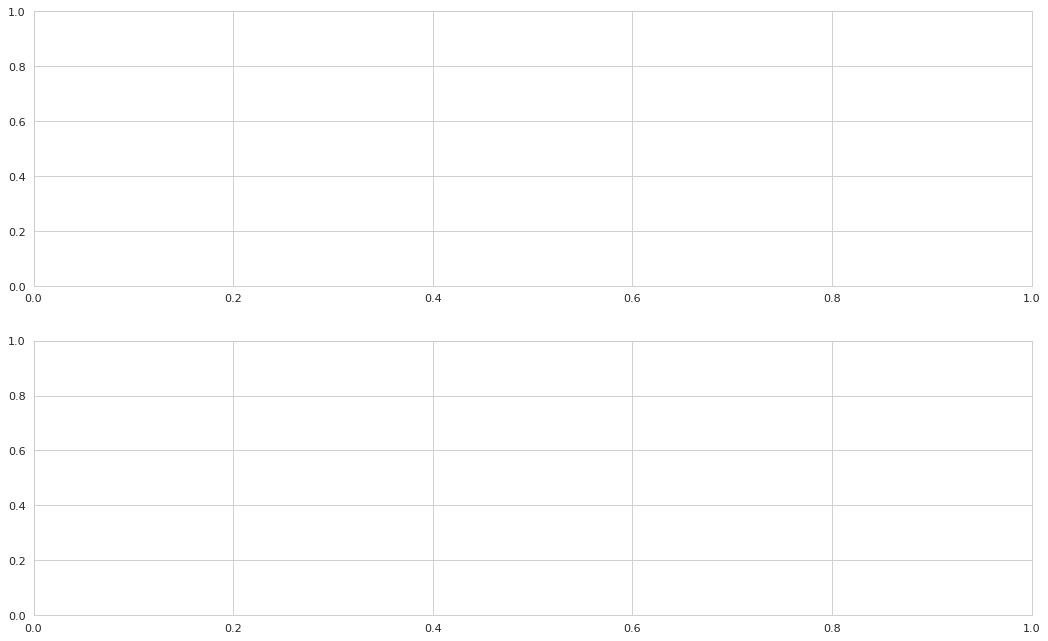

In [38]:
#@markdown Bollinger Bands graphs
fig, axs = plt.subplots(2, figsize=(16.1, 10), dpi=80)
fig.suptitle(f'{CPNY_name} stock (2008-2014)')

# price
axs[0].plot(CPNY.momentum.values, alpha=.7, label='Momentum')
axs[0].set_title('Price (Close daily)')
axs[0].set_xlabel('Timestamp')
axs[0].set_ylabel('Momentum value')


# Momentum
axs[1].plot(CPNY.close.values, alpha=.7, label='Close')
axs[1].plot(CPNY.SMA.values, alpha=.7, label='SMA')
axs[1].set_title('Momentum (14 day period)')
axs[1].set_xlabel('Timestamp')
axs[1].set_ylabel('Close value')

# Display
plt.legend()
plt.show()

|Function|             Name|
|:---|:---|
|TRANGE|               True Range|
|ATR|                  Average True Range|
|NATR|                 Normalized Average True Range|

#### Average Directional Movement Index (ADX)

In [ ]:
#Average Directional Movement Index (ADX)
#@markdown The ADX combines of two other indicators, namely the positive and directional indicators (PLUS_DI and MINUS_DI), which in turn build on the positive and directional movement (PLUS_DM and MINUS_DM). For additional details see [Wikipdia](https://en.wikipedia.org/wiki/Average_directional_movement_index) and [Investopedia](https://www.investopedia.com/articles/trading/07/adx-trend-indicator.asp).
pretty_ploter(CPNY,'ADX')

#### Absolute Price Oscillator (APO)

The absolute Price Oscillator (APO) is computed as the difference between two exponential moving averages (EMA) of price series, expressed as an absolute value. The EMA windows usually contain 26 and 12 data points, respectively.

In [ ]:
# Absolute Price Oscillator (APO)
pretty_ploter(CPNY,'APO')

#### Percentage Price Oscillator (PPO)

The Percentage Price Oscillator (APO) is computed as the difference between two exponential moving averages (EMA) of price series, expressed as a percentage value and thus comparable across assets. The EMA windows usually contain 26 and 12 data points, respectively. 

In [ ]:
# Percentage Price Oscillator (PPO)
pretty_ploter(CPNY,'PPO')

#### Aroon Oscillator (APO)

#### Aroon Up/Down Indicator (PPO)

The indicator measures the time between highs and the time between lows over a time period. It computes an AROON_UP and an AROON_DWN indicator as follows:

$$
\begin{align*}
\text{AROON_UP}&=\frac{T-\text{Periods since T period High}}{T}\times 100\\
\text{AROON_DWN}&=\frac{T-\text{Periods since T period Low}}{T}\times 100
\end{align*}
$$

#### Aroon Oscillator (AROONOSC

The Aroon Oscillator is simply the difference between the Aroon Up and Aroon Down indicators.

In [ ]:
# Aroon Oscillator (AROONOSC)
pretty_ploter(CPNY,'AROONOSC')

#### Balance Of Power (BOP)

The Balance of Power (BOP) intends to measure the strength of buyers relative to sellers in the market by assessing the ability of each side to drive prices. It is computer as the difference between the close and the open price, divided by the difference between the high and the low price: 

$$
\text{BOP}_t= \frac{P_t^\text{Close}-P_t^\text{Open}}{P_t^\text{High}-P_t^\text{Low}}
$$

In [ ]:
# Balance of Power (BOP) indicator
pretty_ploter(CPNY, 'BOP')

#### Commodity Channel Index (CCI)

The Commodity Channel Index (CCI) measures the difference between the current *typical* price, computed as the average of current low, high and close price and the historical average price. A positive (negative) CCI indicates that price is above (below) the historic average. When CCI is below zero, the price is below the hsitoric average. It is computed as:

$$
\begin{align*}
\bar{P_t}&=\frac{P_t^H+P_t^L+P_t^C}{3}\\
\text{CCI}_t & =\frac{\bar{P_t} - \text{SMA}(T)_t}{0.15\sum_{t=i}^T |\bar{P_t}-\text{SMA}(N)_t|/T}
\end{align*}
$$

In [ ]:
# Commodity Channel Index (CCI)
pretty_ploter(CPNY, 'CCI')

#### Moving Average Convergence/Divergence (MACD)

Moving Average Convergence Divergence (MACD) is a trend-following (lagging) momentum indicator that shows the relationship between two moving averages of a security’s price. It is calculated by subtracting the 26-period Exponential Moving Average (EMA) from the 12-period EMA.

The TA-Lib implementation returns the MACD value and its signal line, which is the 9-day EMA of the MACD. In addition, the MACD-Histogram measures the distance between the indicator and its signal line.

In [ ]:
# Moving Average Convergence Divergence (MACD),
plt.figure(figsize=(16.1, 10), dpi=80)

plt.plot(CPNY.macd_fast, label = 'MACD fast')
plt.plot(CPNY.macd_slow, label = 'MACD slow')
plt.plot(CPNY.signal_period, label = 'Signal 9 periods')

plt.xlabel('time')
# Set the y axis label of the current axis.
plt.ylabel('MACD score')
# Set a title of the current axes.
plt.title('Moving average convergence/divergence score')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

#### Chande Momentum Oscillator (CMO)

The Chande Momentum Oscillator (CMO) intends to measure momentum on both up and down days. It is calculated as the difference between the sum of gains and losses over at time period T, divided by the sum of all price movement over the same period. It oscillates between +100 and -100.

In [ ]:
# Chande Momentum Oscillator (CMO)
pretty_ploter(CPNY,'CMO')

#### Money Flow Index

The Money Flow Index (MFI) incorporates price and volume information to identify overbought or oversold conditions.  The indicator is typically calculated using 14 periods of data. An MFI reading above 80 is considered overbought and an MFI reading below 20 is considered oversold.

In [ ]:
# Flow Index (MFI)
pretty_ploter(CPNY,'MFI')

#### Relative Strength Index

RSI compares the magnitude of recent price changes across stocks to identify stocks as overbought or oversold. A high RSI (usually above 70) indicates overbought and a low RSI (typically below 30) indicates oversold. It first computes the average price change for a given number (often 14) of prior trading days with rising and falling prices, respectively as $\text{up}_t$ and $\text{down}_t$. Then, the RSI is computed as:
$$
\text{RSI}_t=100-\frac{100}{1+\frac{\text{up}_t}{\text{down}_t}}
$$



In [ ]:
# Relative Strength Index (RSI)
pretty_ploter(CPNY,'RSI')

#### Stochastic RSI (STOCHRSI)

The Stochastic Relative Strength Index (STOCHRSI) is based on the RSI just described and intends to identify crossovers as well as overbought and oversold conditions. It compares the distance of the current RSI to the lowest RSI over a given time period T to the maximum range of values the RSI has assumed for this period. It is computed as follows:

$$
\text{STOCHRSI}_t= \frac{\text{RSI}_t-\text{RSI}_t^L(T)}{\text{RSI}_t^H(T)-\text{RSI}_t^L(T)}
$$

The TA-Lib implementation offers more flexibility than the original "Unsmoothed stochastic RSI" version by Chande and Kroll (1993). To calculate the original indicator, keep the `timeperiod` and `fastk_period` equal. 

The return value `fastk` is the unsmoothed RSI. The `fastd_period` is used to compute a smoothed STOCHRSI, which  is returned as `fastd`. If you do not care about STOCHRSI smoothing, just set `fastd_period` to 1 and ignore the `fastd` output.

Reference: "Stochastic RSI and Dynamic Momentum Index" by Tushar Chande and Stanley Kroll Stock&Commodities V.11:5 (189-199)


In [ ]:
#Stochastic RSI (STOCHRSI)
plt.figure(figsize=(16.1, 10), dpi=80)
plt.plot(CPNY.fastk, alpha=0.50)
plt.plot(CPNY.fastd, alpha=0.50)

#### Stochastic (STOCH)

A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. Stochastic oscillators are based on the idea that closing prices should confirm the trend.

For stochastic (STOCH), there are four different lines: `FASTK`, `FASTD`, `SLOWK` and `SLOWD`. The `D` is the signal line usually drawn over its corresponding `K` function.

$$
\begin{align*}
& K^\text{Fast}(T_K) & = &\frac{P_t-P_{T_K}^L}{P_{T_K}^H-P_{T_K}^L}* 100 \\
& D^\text{Fast}(T_{\text{FastD}}) & = & \text{MA}(T_{\text{FastD}})[K^\text{Fast}]\\
& K^\text{Slow}(T_{\text{SlowK}}) & = &\text{MA}(T_{\text{SlowK}})[K^\text{Fast}]\\
& D^\text{Slow}(T_{\text{SlowD}}) & = &\text{MA}(T_{\text{SlowD}})[K^\text{Slow}]
\end{align*}
$$
  

The $P_{T_K}^L$, $P_{T_K}^H$, and $P_{T_K}^L$ are the extreme values among the last $T_K$ period.
 $K^\text{Slow}$ and $D^\text{Fast}$ are equivalent when using the same period. 

In [ ]:
#Stochastic (STOCH)
plt.figure(figsize=(16.1, 10), dpi=80)
plt.plot(CPNY.slowk, alpha=0.5)
plt.plot(CPNY.slowd, alpha=0.5)

#### Ultimate Oscillator (ULTOSC)

The Ultimate Oscillator (ULTOSC), developed by Larry Williams, measures the average difference of the current close to the previous lowest price over three time frames (default: 7, 14, and 28) to avoid overreacting to short-term price changes and incorporat short, medium, and long-term market trends. It first computes the buying pressure, $\text{BP}_t$, then sums it over the three periods $T_1, T_2, T_3$, normalized by the True Range ($\text{TR}_t$.
$$
\begin{align*}
\text{BP}_t & = P_t^\text{Close}-\min(P_{t-1}^\text{Close}, P_t^\text{Low})\\ 
\text{TR}_t & = \max(P_{t-1}^\text{Close}, P_t^\text{High})-\min(P_{t-1}^\text{Close}, P_t^\text{Low})
\end{align*}
$$

ULTOSC is then computed as a weighted average over the three periods as follows:
$$
\begin{align*}
\text{Avg}_t(T) & = \frac{\sum_{i=0}^{T-1} \text{BP}_{t-i}}{\sum_{i=0}^{T-1} \text{TR}_{t-i}}\\
\text{ULTOSC}_t & = 100*\frac{4\text{Avg}_t(7) + 2\text{Avg}_t(14) + \text{Avg}_t(28)}{4+2+1}
\end{align*}
$$

In [ ]:
#Ultimate Oscillator (ULTOSC)
pretty_ploter(CPNY,'ULTOSC')

#### Williams' %R (WILLR)

Williams %R, also known as the Williams Percent Range, is a momentum indicator that moves between 0 and -100 and measures overbought and oversold levels to identify entry and exit points. It is similar to the Stochastic oscillator and compares the current closing price $P_t^\text{Close}$ to the range of highest ($P_T^\text{High}$) and lowest ($P_T^\text{Low}$) prices over the last T periods (typically 14). The indicators is computed as:

$$
\text{WILLR}_t = \frac{P_T^\text{High}-P_t^\text{Close}}{P_T^\text{High}-P_T^\text{Low}}
$$


In [ ]:
#Williams' %R (WILLR)
pretty_ploter(CPNY,'WILLR')

## Volume Indicators

|Function|             Name|
|:---|:---|
|AD|                   Chaikin A/D Line|
|ADOSC|                Chaikin A/D Oscillator|
|OBV|                  On Balance Volume|

#### Chaikin A/D Line

The Chaikin Advance/Decline or Accumulation/Distribution Line (AD) is a volume-based indicator designed to measure the cumulative flow of money into and out of an asset. The indicator assumes that the degree of buying or selling pressure can be determined by the location of the close, relative to the high and low for the period. There is buying (sellng) pressure when a stock closes in the upper (lower) half of a period's range. The intention is to signal a change in direction when the indicator diverges from the security price.

The Accumulation/Distribution Line is a running total of each period's Money Flow Volume. It is calculated as follows:

1. The Money Flow Multiplier (MFI) is the relationship of the close to the high-low range:
2. The MFI is multiplied by the period's volume $V_t$ to come up with a Money Flow Volume (MFV). 
3. A running total of the Money Flow Volume forms the Accumulation Distribution Line:
$$
\begin{align*}
&\text{MFI}_t&=\frac{P_t^\text{Close}-P_t^\text{Low}}{P_t^\text{High}-P_t^\text{Low}}\\
&\text{MFV}_t&=\text{MFI}_t \times V_t\\
&\text{AD}_t&=\text{AD}_{t-1}+\text{MFV}_t
\end{align*}
$$

In [39]:
# Chaikin A/D Line
pretty_ploter(CPNY, 'AD')

NameError: ignored

#### Chaikin A/D Oscillator (ADOSC)

The Chaikin A/D Oscillator (ADOSC) is the Moving Average Convergence Divergence indicator (MACD) applied to the Chaikin A/D Line. The Chaikin Oscillator intends to predict changes in the Accumulation/Distribution Line.

It is computed as the difference between the 3-day exponential moving average and the 10-day exponential moving average of the Accumulation/Distribution Line.

In [40]:
#Chaikin A/D Oscillator (ADOSC)
pretty_ploter(CPNY, 'ADOSC')

NameError: ignored

#### On Balance Volume (OBV)

The On Balance Volume indicator (OBV) is a cumulative momentum indicator that relates volume to price change. It assumes that OBV changes precede price changes because smart money can be seen flowing into the security by a rising OBV. When the public then moves into the security, both the security and OBV will rise.

The current OBV is computed by adding (subtracting) the current volume to the last OBV if the security closes higher (lower) than the previous close.

$$
\text{OBV}_t = 
\begin{cases}
\text{OBV}_{t-1}+V_t & \text{if }P_t>P_{t-1}\\
\text{OBV}_{t-1}-V_t & \text{if }P_t<P_{t-1}\\
\text{OBV}_{t-1} & \text{otherwise}
\end{cases}
$$

In [ ]:
#On Balance Volume (OBV)
pretty_ploter(CPNY, 'OBV')

## Volatility Indicators

### ATR

The Average True Range indicator (ATR) shows volatility of the market. It was introduced by Welles Wilder (1978)  and has been used as a component of numerous other indicators since. It aims to anticipate changes in trend such that the higher its value, the higher the probability of a trend change; the lower the indicator’s value, the weaker the current trend.

It is computed as the simple moving average for a period T of the True Range (TRANGE), which measures volatility as the absolute value of the largest recent trading range:
$$
\text{TRANGE}_t = \max\left[P_t^\text{High} - P_t^\text{low}, \left| P_t^\text{High} - P_{t-1}^\text{Close}\right|, \left| P_t^\text{low} - P_{t-1}^\text{Close}\right|\right]
$$

In [ ]:
# ATR
pretty_ploter(CPNY, 'ATR')

### NATR

The Normalized Average True Range (NATR) is a normalized version of the ATR computed as follows:

$$
\text{NATR}_t = \frac{\text{ATR}_t(T)}{P_t^\text{Close}} * 100
$$

Normalization make the ATR function more relevant in the folllowing scenarios:
- Long term analysis where the price changes drastically.
- Cross-market or cross-security ATR comparison.

In [ ]:
#NATR
pretty_ploter(CPNY, 'NATR')

## Rolling Factor Betas

# Persist results

In [52]:
r=Returns(data)
m=Metrics(data)
DATA_STORE = Path('..', 'data', 'stock_metrics.h5')
store = pd.HDFStore(DATA_STORE)
for company_name in progress_bar(set(data.index.get_level_values(0))):
    returns = r.all_returns(company_name)
    metrics = m.all_metrics(company_name)
    store[f'data/{company_name}'] = returns.join(metrics)
store.close()